# Snakemake Tutorial
## Using Snakemake in everyday bioinformatics tasks
This tutorial will walk you through creating a workflow for a relatively simple bioinformatics application. 

### A note on Abstraction

#### Modular and incomprehensible
Snakemake is a powerful programming language for building and deploying workflows on a large scale. It provides many abstraction tools or ways to generalize rules to apply to many different cases. This usually makes mature workflows hard to understand at first glance. 

If you look at the code in my workflows repository, you’ll see a tendency to overuse abstraction. As a result, much of the code can be reused in multiple different workflows, but it’s really hard to follow what’s going on in any particular workflow.
#### Single use
You can chose to skip the abstraction altogether and explicitly name every file you wish to use. This makes the workflow much easier to write and to understand, but harder to reuse.
#### Finding a balance
I would suggest finding a balance. In this tutorial we’ll start by creating a single use workflow with every file name explicitly specified. ONce we get going, we’ll add a small touch of abstraction that will make our workflow more generally useful with little effort and almost no loss of readability. It may even make it easier to understand.

There are more things that can be done without affecting readability, but it’s a slippery slope, so we’ll start with just this one.

### Setting up
The workflow we’re building in this tutorial will identify and count taxa using rRNA fragments in a fastq file of transcriptomic reads.

We’ll need a few things:
 
 * some fastq files to play with
 * the rRNA models from RFAM
 * the Silva SSU fasta database
 * a few bits of softaware (bwa, infernal, etc) that should already be installed via conda
 
Conda env:

The conda environment running this notebook should have been set up with the command:
```
 $ conda env create -n tutorial -f conda.yml
```

Where conda.yml looks like this:

In [ ]:
# %load ../conda.yml
channels:
    - bioconda
    - conda-forge
    - jmeppley
dependencies:
    - python=3.5
    - snakemake
    - infernal
    - py-metagenomics
    - bwa
    - seqtk
    - jupyter

### A first makefile
#### makefile or snakefile
First a note on my use of the words snakefile and makefile. Makefile is the term used for a workflow file written for gnu make or any of its relatives (eg cmake). Snakemake calls its files “Snakefiles”. I really don’t like this term on purely aesthetic grounds so I use “makefile” in a general sense to describe any text document defining (part of) a workflow as a set of rules.

#### Test data
Let’s create an empty temporary directory to work in. In this directory, we'll put a fastq file to start with:

In [1]:
!rm -rf tmp_1
!mkdir tmp_1
%cd tmp_1
!cp ../../data/my.reads.fastq ./

/Users/jmeppley/work/snakemake_tutorial/notebooks/tmp_1


#### rRNA identification
We’ll use the rRNA models that come with the workflows (and are originally from RFAM) to identify sequences in our data. The command should look something like this:

```
 $ cmsearch --hmmonly -o /dev/null --tblout output.tbl --cpu 10             /slipstream/home/jmeppley/work/workflows/annotation/models/rRNA.cm my.reads.fasta
```

In [2]:
!cmsearch --hmmonly -o /dev/null --tblout output.tbl --cpu 10  ../../data/rRNA.cm my.reads.fastq


Error: Parse failed (sequence file my.reads.fastq):
Line 1: unexpected char @; expected FASTA to start with >



We already have a problem. The input is expected in fasta format, but we have fastq. We’ll need to use seqtk first:

```
 $ seqtk seq -A my.reads.fastq > my.reads.fasta
```

It's time to create a small makefile to chain the two rules together:

In [3]:
%%writefile Snakefile
rule find_rrna:
  input: "my.reads.fasta"
  output: "my.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "my.reads.fastq"
  output: "my.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"

Writing Snakefile


Now you can run it with the `snakemake` command:

In [4]:
!rm ./my.reads.fasta ./my.reads.rrna.cmsearch.tbl

rm: ./my.reads.fasta: No such file or directory
rm: ./my.reads.rrna.cmsearch.tbl: No such file or directory


In [5]:
%%bash
snakemake -p

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	fastq_to_fasta
	1	find_rrna
	2

rule fastq_to_fasta:
    input: my.reads.fastq
    output: my.reads.fasta
    jobid: 1

seqtk seq -A my.reads.fastq > my.reads.fasta
Finished job 1.
1 of 2 steps (50%) done

rule find_rrna:
    input: my.reads.fasta
    output: my.reads.rrna.cmsearch.tbl
    jobid: 0

cmsearch --hmmonly -o /dev/null --tblout my.reads.rrna.cmsearch.tbl --cpu 10 ../../data/rRNA.cm my.reads.fasta
Finished job 0.
2 of 2 steps (100%) done


In about a minute, you’ll get your cmsearch results!

#### Breaking it Down
Now you have created a makefile and run snakemake. How did it work?

##### Rules
Each rule in the snakefiel corresponds to a step of the workflow. A rule usually has inputs, outputs, and some sort of action to take. Generally, one rule runs one command.  

###### input:
This defines the input of a rule. It can be a single file or multiple files. The indicated file(s) must exist before the rule can be run.

###### output:
This defines the output file or files. The rule is only run if any of the output files is missing or is older than any of the the input files. 

###### params:
This defines any number of named values that can be used in the command. In the above case, it’s unnecessary, since we could just put the db path in the command. However, I think it simplifies the command. It can also be useful if you want to determine the database location dynamically in a later version of the makefile.

###### shell:
This contains the snippet of bash to be run. As stated above, this is usually a single command. It behaves almost exactly as if you had typed it into your command prompt with a few exceptions explained here. 

The “shell:” directive can be a larger chunk of bash that contains multiple commands. This makes sense if you feel that conceptually they are all part of the same step. In general, though, you want to avoid combining multiple commands into one step, because it makes your workflow much harder to debug. 

A rule can also run a snippet of python code (using the keyword "run:" instead of "shell:"). This can be really handy for the little things that need to happen along the way that can’t be done easily with off the shelf software. I also use it at the end of some workflows to report some basic statistics. Because that code is only relevant to the specific workflow, there is no need to put it into its own script.

##### Rule order
You’ll notice that the makefile starts with the last rule to be run. This is because the convention is for the first rule to be run if needed. All the other rules are only run if they are needed to complete the first rule.

Another common approach is to put a dummy rule at the start that only defines input files. Since it has no output, it gets run every time. Since it has no “shell” or “run” directive, nothing actually happens when it is run. However, snakemake will make sure that all of its input files are updated if necessary before running the first rule. So, if the input files of that first rule are the files you want the workflow to produce, snakemake will figure out how to produce those files. 

If we had written the makefile like this:

```
rule outputs:
    input: “my.reads.rrna.cmsearch.tbl”

rule fastq_to_fasta:
    . . .

rule find_rrna:
    . . . 
```

Snakemake would figure out that find_rrna needs to be run to make the .tbl file AND that fastq_to_fasta needs to be run before that.

#### Add Abstraction
The makefile you just created is nice, but if you have two or more files to process, you can't have the file names hard-coded into the rule inputs. You can get around this by putting wildcards into you input and output declarations.

As mentioned above, too much abstraction can get confusing, but a little can be powerful. Since this is a very common use case and the confusion is minimal, it’s usually worth it.

##### Add wildcards
Modify the makefile to put a sample name place holder anywhere we used “my”:

In [6]:
%%writefile Snakefile
rule find_rrna:
  input: "{sample}.reads.fasta"
  output: "{sample}.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "{sample}.reads.fastq"
  output: "{sample}.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"

Overwriting Snakefile


Notice that "my" has been replaced by "{sample}" all over the makefile. Now we can supply a file with a different prefix, and the workflow will apply the same rules:

In [7]:
%%bash
cp ../../data/other.reads.fastq ./
snakemake -p

WorkflowError:
Target rules may not contain wildcards. Please specify concrete files or a rule without wildcards.


##### What happened?
If a specific output file is not specified, Snakemake uses the first rule as the "target". If the target rule uses wild cards for input and output files, snakmake doesn't know what to do.

We can work around this by manually specifying the output file:

In [8]:
%%bash
snakemake -p my.reads.rrna.cmsearch.tbl

Nothing to be done.


However, you'd have to list every file you want to create. 

You can use BASH to loop over the fastq files:
```
 $ for FASTQ_FILE in *.reads.fastq; do 
 > snakemake ${FASTQ_FILE%%.fastq}.rrna.cmsearch.tbl
 > done
```

Or you can put that logic into a new target rule in the makefile, using python.

First, we'll use python to generate the list of samples from the available fastq files:

In [9]:
import glob
fastq_files = glob.glob("*.reads.fastq")
print(fastq_files)

['my.reads.fastq', 'other.reads.fastq']


In [10]:
import re
for f in fastq_files:
    sample = re.sub(r'\.reads\.fastq','',f)
    print("{} -> {}".format(f, sample))

my.reads.fastq -> my
other.reads.fastq -> other


Putting it into the makefile in a more concise notation, and use snakemake's `expand` function to generate the outputs files:

In [16]:
%%writefile Snakefile

# load some python modules to help us out
import glob, re

# define a sample for each *.reads.fastq file
samples = [re.sub(r'\.reads\.fastq','',f) \
           for f in glob.glob('*.reads.fastq')]

rule target:
  """ generate a cmsearch table for every sample """
  input: expand("{sample}.reads.rrna.cmsearch.tbl", sample=samples)
        
rule find_rrna:
  input: "{sample}.reads.fasta"
  output: "{sample}.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "{sample}.reads.fastq"
  output: "{sample}.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"

Overwriting Snakefile


It uses the glob and re Python libraries creates a list of samples from all the files that look like sample.reads.fastq. Then it uses that list of samples and snakemake’s expand() function to generate the list of final output files.

Now, running `snakemake` will generate both .tbl files!

In [15]:
%%bash
snakemake -p

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	fastq_to_fasta
	1	find_rrna
	1	target
	3

rule fastq_to_fasta:
    input: other.reads.fastq
    output: other.reads.fasta
    jobid: 4
    wildcards: sample=other

seqtk seq -A other.reads.fastq > other.reads.fasta
Finished job 4.
1 of 3 steps (33%) done

rule find_rrna:
    input: other.reads.fasta
    output: other.reads.rrna.cmsearch.tbl
    jobid: 2
    wildcards: sample=other

cmsearch --hmmonly -o /dev/null --tblout other.reads.rrna.cmsearch.tbl --cpu 10 ../../data/rRNA.cm other.reads.fasta
Finished job 2.
2 of 3 steps (67%) done

localrule target:
    input: my.reads.rrna.cmsearch.tbl, other.reads.rrna.cmsearch.tbl
    jobid: 0

Finished job 0.
3 of 3 steps (100%) done


Except it won’t cerate both, because one already exists! Snakemake won’t re-run a rule if the input file is older than the output Note that only the new file ("other") was processed, since the first sample has already been done!

#### Growing the makefile
Now we have a makefile that will run a couple rules on any number of fast files in the current directory. Let’s add a few more rules to make it more useful.

We have a list of reads that match the rRNA models from RFAM, but what organisms are they. Let’s pull out things that matched the SSU model and search Silva for them.

##### SSU only
Identify reads
The Silva SSU database has some contamination from LSU and other sources, so let’s only use reads that match the SSU HMMs.

```
rule filter_rrna_tbl:
    input: "{sample}.reads.rrna.cmsearch.tbl"
    output: "{sample}.reads.rrna.cmsearch.SSU.tbl"
    shell: "grep SSU {input} > {output}"
```

##### Isolate reads
We need to pull out just the matching reads from the fastq:

```
rule filter_rrna:
    """ Pull rRNA reads out of a fastq file using cmsearch hits """
    input:
        reads="{sample}.reads.fastq",
        hits="{sample}.reads.rrna.cmsearch.SSU.tbl"
    output: "{sample}.SSU.fastq"
    shell:
        "screen_list.py -k -l {input.hits} -C 0 -f fastq -v {input.reads} > {output} 2> {output}.log"
```

###### Map to Silva
Find the best hit in Silva using the DBs configured for Galaxy:

```
rule map_reads_to_silva:
    input: "{sample}.SSU.fastq"
    output: "{sample}.SSU.vs.Silva.sam"
    params:
        db='/mnt/histidine/galaxydata/seqdbs/Silva/123_1/Silva_123_SSURef_NR99/bwadb'
    shell: "bwa mem -t 15 {params.db} {input} > {output} 2> {output}.log"
```

In [11]:
%%writefile Snakefile

# we'll leave out the target rule for now until we get to the final version

rule map_reads_to_silva:
    input: "{sample}.SSU.fastq"
    output: "{sample}.SSU.vs.Silva.sam"
    params:
        db='../../data/Silva.SSU.fasta'
    shell: "bwa mem -t 15 {params.db} {input} > {output} 2> {output}.log"

rule filter_rrna:
    """ Pull rRNA reads out of a fastq file using cmsearch hits """
    input:
        reads="{sample}.reads.fastq",
        hits="{sample}.reads.rrna.cmsearch.SSU.tbl"
    output: "{sample}.SSU.fastq"
    shell:
        "screen_list.py -k -l {input.hits} -C 0 -f fastq -v {input.reads} > {output} 2> {output}.log"

rule filter_rrna_tbl:
    input: "{sample}.reads.rrna.cmsearch.tbl"
    output: "{sample}.reads.rrna.cmsearch.SSU.tbl"
    shell: "grep SSU {input} > {output}"        

rule find_rrna:
  """ Search for sequences that look like rRNA """
  input: "{sample}.reads.fasta"
  output: "{sample}.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "{sample}.reads.fastq"
  output: "{sample}.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"

Overwriting Snakefile


In [12]:
%%bash
# Let’s test this out on one of the samples:

snakemake -p my.SSU.vs.Silva.sam

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	filter_rrna
	1	filter_rrna_tbl
	1	map_reads_to_silva
	3

rule filter_rrna_tbl:
    input: my.reads.rrna.cmsearch.tbl
    output: my.reads.rrna.cmsearch.SSU.tbl
    jobid: 2
    wildcards: sample=my

grep SSU my.reads.rrna.cmsearch.tbl > my.reads.rrna.cmsearch.SSU.tbl
Finished job 2.
1 of 3 steps (33%) done

rule filter_rrna:
    input: my.reads.fastq, my.reads.rrna.cmsearch.SSU.tbl
    output: my.SSU.fastq
    jobid: 1
    wildcards: sample=my

screen_list.py -k -l my.reads.rrna.cmsearch.SSU.tbl -C 0 -f fastq -v my.reads.fastq > my.SSU.fastq 2> my.SSU.fastq.log
Finished job 1.
2 of 3 steps (67%) done

rule map_reads_to_silva:
    input: my.SSU.fastq
    output: my.SSU.vs.Silva.sam
    jobid: 0
    wildcards: sample=my

bwa mem -t 15 ../../data/Silva.SSU.fasta my.SSU.fastq > my.SSU.vs.Silva.sam 2> my.SSU.vs.Silva.sam.log
Error in job map_reads_to_silva while creating output file my.SSU.vs.Silva

##### What went wrong?

In [13]:
!cat my.SSU.vs.Silva.sam.log

[E::bwa_idx_load_from_disk] fail to locate the index files


We forgot to index the fast file for BWA. No problem, we'll add a rule for that:

```
rule index_bwa_db:
    """ create an indexed fasta file for bwa """
    input: "{fasta_file}"
    output: "{fasta_file}.bwt"
    shell: "bwa index {input}"
```

Note that in this case, the output file is not explicitly created. It's implied by the command. 

We also need to alter the bwa rule to require the indexed fasta as an input:

```
rule map_reads_to_silva:
    """ The Silva index is an input, but we only give the root file name as an argument """
    input: 
        fastq="{sample}.SSU.fastq",
        index="../../data/Silva.SSU.fasta.bwt"
    output: "{sample}.SSU.vs.Silva.sam"
    params:
        index='../../data/Silva.SSU.fasta'
    shell: "bwa mem -t 15 {params.index} {input.fastq} > {output} 2> {output}.log"
```

Here we use a the index parameter to define the command-line option for the inde, eventhough we tell use the actual *.bwt file as the input.

In [18]:
%%writefile Snakefile

rule index_bwa_db:
    """ create an indexed fasta file for bwa """
    input: "{fasta_file}"
    output: "{fasta_file}.bwt"
    log: "{fasta_file}.log"
    shell: "bwa index {input} > {log} 2>&1"
        
rule map_reads_to_silva:
    """ The Silva index is an input, but we only give the root file name as an argument """
    input: 
        fastq="{sample}.SSU.fastq",
        index="../../data/Silva.SSU.fasta.bwt"
    output: "{sample}.SSU.vs.Silva.sam"
    params:
        db='../../data/Silva.SSU.fasta'
    shell: "bwa mem -t 15 {params.db} {input.fastq} > {output} 2> {output}.log"
        
rule filter_rrna:
    """ Pull rRNA reads out of a fastq file using cmsearch hits """
    input:
        reads="{sample}.reads.fastq",
        hits="{sample}.reads.rrna.cmsearch.SSU.tbl"
    output: "{sample}.SSU.fastq"
    shell:
        "screen_list.py -k -l {input.hits} -C 0 -f fastq -v {input.reads} > {output} 2> {output}.log"

rule filter_rrna_tbl:
    input: "{sample}.reads.rrna.cmsearch.tbl"
    output: "{sample}.reads.rrna.cmsearch.SSU.tbl"
    shell: "grep SSU {input} > {output}"        

rule find_rrna:
  """ Search for sequences that look like rRNA """
  input: "{sample}.reads.fasta"
  output: "{sample}.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "{sample}.reads.fastq"
  output: "{sample}.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"

Overwriting Snakefile


In [20]:
!snakemake -p my.SSU.vs.Silva.sam

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	index_bwa_db
	1	map_reads_to_silva
	2

rule index_bwa_db:
    input: ../../data/Silva.SSU.fasta
    output: ../../data/Silva.SSU.fasta.bwt
    log: ../../data/Silva.SSU.fasta.log
    jobid: 2
    wildcards: fasta_file=../../data/Silva.SSU.fasta

bwa index ../../data/Silva.SSU.fasta > ../../data/Silva.SSU.fasta.log 2>&1
Finished job 2.
1 of 2 steps (50%) done

rule map_reads_to_silva:
    input: ../../data/Silva.SSU.fasta.bwt, my.SSU.fastq
    output: my.SSU.vs.Silva.sam
    jobid: 0
    wildcards: sample=my

bwa mem -t 15 ../../data/Silva.SSU.fasta my.SSU.fastq > my.SSU.vs.Silva.sam 2> my.SSU.vs.Silva.sam.log
Finished job 0.
2 of 2 steps (100%) done


In [22]:
!head -5 my.SSU.vs.Silva.sam

@SQ	SN:U85846.1.1486	LN:1486
@SQ	SN:AB013833.1.1485	LN:1485
@SQ	SN:AB013824.1.1531	LN:1531
@SQ	SN:AB013825.1.1526	LN:1526
@SQ	SN:AB019757.1.1403	LN:1403


In [24]:
!grep -m 2 -v "^@" my.SSU.vs.Silva.sam

NS500472:38:H7337AFXX:1:11101:17936:1013	0	DQ394992.1.1513	103	4	151M	*	0	0	GTAACNCGTAGGAATCTGCCCAGTAGTGGGGGACAACCCGAGGAAACTCGGGCTAATACCGCATGCGCCCTACGGGGGAAAGCGGGGGACTTTCGGGCCTCGCGCTATTGGATGAGCCTGCGTCGGATTAGCTTGTTGGTGAGGTAATGGC	AAAAA#EEEAEEEEEEEEEEEEEEAEEEEEEEEEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEE/EEEEAEEEEEEEEEEEEEEEEEE/EEEEEEEEEEEEEEEEEEEEEEEEAEE<EAEAEE<AEAAEEA<EE/EEEAAAEAAAE/EAA/	NM:i:6	MD:Z:5G58A24T0C5A44G9	AS:i:124	XS:i:120	XA:Z:HQ674054.1.1516,+123,151M,7;JN166297.1.1518,+123,151M,8;AY627372.1.1519,+94,147M4S,9;
NS500472:38:H7337AFXX:1:11101:13190:1013	0	HQ673902.1.1520	520	20	151M	*	0	0	TGCCGNGGTAATACGAGGGGGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGTTCGTAGGCGGATTAGTAAGTCTGTATTGAAATACAATGGCTTAACCATTGAAACAGTATGGATACTGCTAATCTTGAATTATGTAGAGGTAAGTG	AAAAA#EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEE/EEEEEE<EEEEEEEEEEEEEEEEEAEEEE/EEEEEEEEEEEEEE<EEE/EEEEEEEEEEEEEEEEEEE/EEE<E<<EAEEAE/EEEEEE/EEAEE/AAE/	NM:i:4	MD:Z:0A4C60G11A72	AS:i:138	XS:i:128	XA:Z:JN166217.1.1521,+520,151M,6;


#### Taxonomic counts
We now have a table of Silva hits to our SSU reads. They’d be more useful as taxonomic counts. Let’s add a rule to generate those:

We'll use my count_taxa.py script which should look something like this:

```
count_taxa.py {input} -f sam -o {output} -r genus -F 0 -C LCA \
         -R domain -R phylum -R class -R order -R family -n {taxdump} -m {taxmap}"
```

This script will: (1) identify the top scoring hits from each read (2) look up the taxon for each hit (3) count how many times each taxon appears and (4) print out a table of totals.

The rule might look like:

```
rule count_taxa:
    """ count the number of times each taxon was spotted """
    input: "{sample}.SSU.vs.Silva.sam"
    output: "{sample}.SSU.counts.tsv"
    params:
        taxdump="../../data",
        taxmap="../../data/Silva.SSU.tax"
    shell:
        "count_taxa.py {input} -f sam -o {output} \
         -r genus -F 0 -C LCA \
         -R domain -R phylum -R class -R order -R family \
         -n {params.taxdump} -m {params.taxmap}"
```

The `-r genus` options tells the script to collect counts at the genus level, while the `-R {rank}` options list all the intermediate ranks to print.

##### More abstraction: configurable parameters
Before we add it to the makefile, though, let's make it a little more flexible.

What if we wanted counts other than just at the genus level? We could edit the makefile to change the genus and the name of the output file so we don’t overwrite it. Or we can use wildcards again. But this time, instead of looking up the values from what’s in our folder already, we can pass in at run time.

We first edit that last rule to get the rank from the file name:

```
rule count_taxa:
    """ count the number of times each taxon was spotted """
    input: "{sample}.SSU.vs.Silva.sam"
    output: "{sample}.SSU.{rank}.counts.tsv"
    params:
        taxdump="../../data",
        taxmap="../../data/Silva.SSU.tax"
    shell:
        "count_taxa.py {input} -f sam -o {output} \
         -r {wildcards.rank} -F 0 -C LCA \
         -R domain -R phylum -R class -R order -R family \
         -n {params.taxdump} -m {params.taxmap}"
```

Notice that there are only two small changes. We’ve included the {rank} wildcard in our output file name and also replaced “genus” with “{wildcards.rank}” in the shell command. Now if we run the makefile with the appropriately named target, we’ll can choose the rank on the fly:

In [27]:
%%writefile Snakefile

rule count_taxa:
    """ count the number of times each taxon was spotted """
    input: "{sample}.SSU.vs.Silva.sam"
    output: "{sample}.SSU.{rank}.counts.tsv"
    params:
        taxdump="../../data",
        taxmap="../../data/Silva.SSU.tax"
    shell:
        "count_taxa.py {input} -f sam -o {output} \
         -r {wildcards.rank} -F 0 -C LCA \
         -R domain -R phylum -R class -R order -R family \
         -n {params.taxdump} -m {params.taxmap}"

rule index_bwa_db:
    """ create an indexed fasta file for bwa """
    input: "{fasta_file}"
    output: "{fasta_file}.bwt"
    log: "{fasta_file}.log"
    shell: "bwa index {input} > {log} 2>&1"
        
rule map_reads_to_silva:
    """ The Silva index is an input, but we only give the root file name as an argument """
    input: 
        fastq="{sample}.SSU.fastq",
        index="../../data/Silva.SSU.fasta.bwt"
    output: "{sample}.SSU.vs.Silva.sam"
    params:
        db='../../data/Silva.SSU.fasta'
    shell: "bwa mem -t 15 {params.db} {input.fastq} > {output} 2> {output}.log"
        
rule filter_rrna:
    """ Pull rRNA reads out of a fastq file using cmsearch hits """
    input:
        reads="{sample}.reads.fastq",
        hits="{sample}.reads.rrna.cmsearch.SSU.tbl"
    output: "{sample}.SSU.fastq"
    shell:
        "screen_list.py -k -l {input.hits} -C 0 -f fastq -v {input.reads} > {output} 2> {output}.log"

rule filter_rrna_tbl:
    input: "{sample}.reads.rrna.cmsearch.tbl"
    output: "{sample}.reads.rrna.cmsearch.SSU.tbl"
    shell: "grep SSU {input} > {output}"        

rule find_rrna:
  """ Search for sequences that look like rRNA """
  input: "{sample}.reads.fasta"
  output: "{sample}.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "{sample}.reads.fastq"
  output: "{sample}.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"

Overwriting Snakefile


In [28]:
!snakemake my.SSU.domain.counts.tsv

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	count_taxa
	1

rule count_taxa:
    input: my.SSU.vs.Silva.sam
    output: my.SSU.domain.counts.tsv
    jobid: 0
    wildcards: rank=domain, sample=my

Finished job 0.
1 of 1 steps (100%) done


This gives us very high level counts:

In [29]:
! cat my.SSU.domain.counts.tsv

Taxon	my.SSU.vs.Silva.sam
Archaea	28
Bacteria	220
Eukaryota	21


In [30]:
!snakemake my.SSU.genus.counts.tsv

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	count_taxa
	1

rule count_taxa:
    input: my.SSU.vs.Silva.sam
    output: my.SSU.genus.counts.tsv
    jobid: 0
    wildcards: sample=my, rank=genus

Finished job 0.
1 of 1 steps (100%) done


This gives us more detailed counts:

In [33]:
!head -5 my.SSU.genus.counts.tsv

Taxon	my.SSU.vs.Silva.sam
Archaea	11
Archaea;Thaumarchaeota;MarineGroupI;;;unculturedarchaeon(MarineGroupI)	3
Archaea;Thaumarchaeota;MarineGroupI;;;unculturedmarinegroupIthaumarchaeote(MarineGroupI)	7
Archaea;Thaumarchaeota;MarineGroupI;UnknownOrder;UnknownFamily;CandidatusNitrosopelagicus	7


#### Putting it all together

We have now built up a workflow that takes us from fastq to taxonomic counts. Let’s package it nicely so that we can re-use it on any number of sampes. 

We need to restore the target rule. This time the final output file will be:
```
{sample}.SSU.{rank}.counts.tsv
```

We can generate the list of samples as before, but how do we tell the script which rank to generate? 

##### Configuration
The `config` object gives us a way to pass in values from the command line. It behaves like a python dictionary. So if we add
```
--config rank=order
```
to our command, we will have an object in the makefile that looks like:

In [36]:
config = {'rank': 'order'}

It's good practice to have a default value for configuration paramters. The easiest way to do that is using the dictionary's `setdefault` function:

In [37]:
rank = config.setdefault('rank', 'genus')
print(rank)

order


In [38]:
del config['rank']
rank = config.setdefault('rank', 'genus')
print(rank)

genus


Here is what the final makefile might look like:

In [41]:
%%writefile Snakefile
import glob, re

# define a sample for each *.reads.fastq file
samples = [re.sub(r'\.reads\.fastq','',f) \
           for f in glob.glob('*.reads.fastq')]

# We add a hook to get a list of taxonomic ranks from the configuration
#  I've added a little python to allow multiple ranks
ranks = config.setdefault('ranks', 'domain,genus').split(",")

# When we run the workflow, we’ll use the `--config` flag to pass a key=value pair into the “config” dictionary. 
# This configuration object (see here and here) is a powerful tool for generalizing workflows and rules, 
# but it can quickly add complexity to a workflow, so use it sparingly at first.

# We’ll update our target rule to do counts at all requested ranks for all samples:
rule target:
  """ generate a count table for every sample at requested ranks """
  input: 
        expand("{sample}.SSU.{rank}.counts.tsv", 
                sample=samples, 
                rank=ranks)

# We complete our makefile with the substantive rules from above:
rule count_taxa:
    """ count the number of times each taxon was spotted """
    input: "{sample}.SSU.vs.Silva.sam"
    output: "{sample}.SSU.{rank}.counts.tsv"
    params:
        taxdump="../../data",
        taxmap="../../data/Silva.SSU.tax"
    shell:
        "count_taxa.py {input} -f sam -o {output} \
         -r {wildcards.rank} -F 0 -C LCA \
         -R domain -R phylum -R class -R order -R family \
         -n {params.taxdump} -m {params.taxmap}"

rule index_bwa_db:
    """ create an indexed fasta file for bwa """
    input: "{fasta_file}"
    output: "{fasta_file}.bwt"
    log: "{fasta_file}.log"
    shell: "bwa index {input} > {log} 2>&1"
        
rule map_reads_to_silva:
    """ The Silva index is an input, but we only give the root file name as an argument """
    input: 
        fastq="{sample}.SSU.fastq",
        index="../../data/Silva.SSU.fasta.bwt"
    output: "{sample}.SSU.vs.Silva.sam"
    params:
        db='../../data/Silva.SSU.fasta'
    shell: "bwa mem -t 15 {params.db} {input.fastq} > {output} 2> {output}.log"
        
rule filter_rrna:
    """ Pull rRNA reads out of a fastq file using cmsearch hits """
    input:
        reads="{sample}.reads.fastq",
        hits="{sample}.reads.rrna.cmsearch.SSU.tbl"
    output: "{sample}.SSU.fastq"
    shell:
        "screen_list.py -k -l {input.hits} -C 0 -f fastq -v {input.reads} > {output} 2> {output}.log"

rule filter_rrna_tbl:
    input: "{sample}.reads.rrna.cmsearch.tbl"
    output: "{sample}.reads.rrna.cmsearch.SSU.tbl"
    shell: "grep SSU {input} > {output}"        

rule find_rrna:
  """ Search for sequences that look like rRNA """
  input: "{sample}.reads.fasta"
  output: "{sample}.reads.rrna.cmsearch.tbl"
  params:
    model = "../../data/rRNA.cm"
  shell: 
    "cmsearch --hmmonly -o /dev/null --tblout {output} --cpu 10 {params.model} {input}"

rule fastq_to_fasta:
  input: "{sample}.reads.fastq"
  output: "{sample}.reads.fasta"
  shell: "seqtk seq -A {input} > {output}"
    

Overwriting Snakefile


In [42]:
#Now you can run this workflow with
!snakemake --config ranks=phylum,order,genus

Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	5	count_taxa
	1	fastq_to_fasta
	1	filter_rrna
	1	filter_rrna_tbl
	1	find_rrna
	1	map_reads_to_silva
	1	target
	11

rule fastq_to_fasta:
    input: other.reads.fastq
    output: other.reads.fasta
    jobid: 16
    wildcards: sample=other

Finished job 16.
1 of 11 steps (9%) done

rule find_rrna:
    input: other.reads.fasta
    output: other.reads.rrna.cmsearch.tbl
    jobid: 14
    wildcards: sample=other

Finished job 14.
2 of 11 steps (18%) done

rule filter_rrna_tbl:
    input: other.reads.rrna.cmsearch.tbl
    output: other.reads.rrna.cmsearch.SSU.tbl
    jobid: 12
    wildcards: sample=other

Finished job 12.
3 of 11 steps (27%) done

rule filter_rrna:
    input: other.reads.rrna.cmsearch.SSU.tbl, other.reads.fastq
    output: other.SSU.fastq
    jobid: 9
    wildcards: sample=other

Finished job 9.
4 of 11 steps (36%) done

rule map_reads_to_silva:
    input: ../../data/Silva.SSU.fasta.bwt

Now we have six count files: three ranks for two samples!

Note that it only ran the filter and mapping rules for the "other" sample, since those rules were complete for the "my" sample.

In [44]:
!ls -lrth *.tsv

-rw-r--r--  1 jmeppley  staff    63B Aug 23 08:12 my.SSU.domain.counts.tsv
-rw-r--r--  1 jmeppley  staff   2.5K Aug 23 08:12 my.SSU.genus.counts.tsv
-rw-r--r--  1 jmeppley  staff   342B Aug 23 08:26 other.SSU.order.counts.tsv
-rw-r--r--  1 jmeppley  staff   684B Aug 23 08:26 other.SSU.genus.counts.tsv
-rw-r--r--  1 jmeppley  staff   148B Aug 23 08:26 other.SSU.phylum.counts.tsv
-rw-r--r--  1 jmeppley  staff   417B Aug 23 08:26 my.SSU.phylum.counts.tsv
-rw-r--r--  1 jmeppley  staff   1.7K Aug 23 08:26 my.SSU.order.counts.tsv


(The "domain" counts are still there from before, so we have 7 files.)

### Meta Data
Snakemake has a couple built in tools for summarizing what just happened.

In [50]:
!snakemake --config ranks=phylum,order,genus --dag | dot -Tpng > dag.png

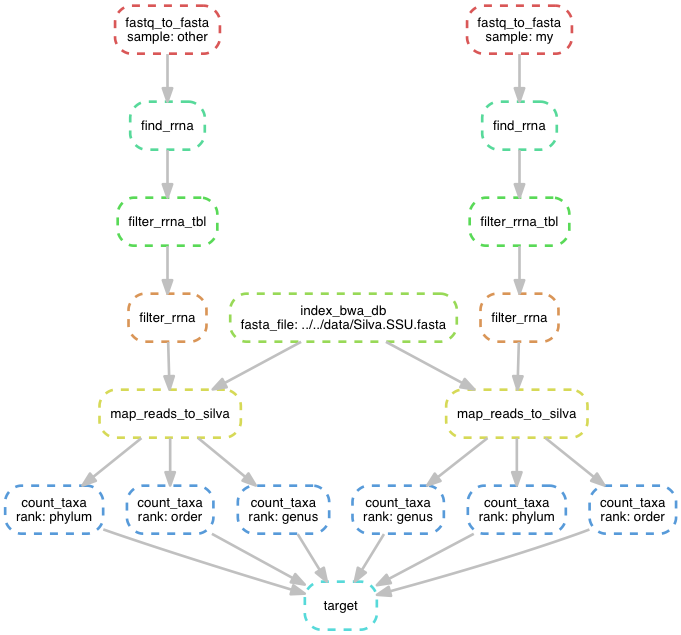

In [51]:
from IPython.display import Image
Image(filename='dag.png') 

In [59]:
!snakemake --config ranks=phylum,order,genus -D

output_file	date	rule	version	log-file(s)	input-file(s)	shellcmd	status	plan
my.SSU.genus.counts.tsv	Wed Aug 23 08:12:48 2017	-	-	-	-	-	ok	update pending
other.SSU.genus.counts.tsv	Wed Aug 23 08:26:14 2017	-	-	-	-	-	ok	update pending
other.SSU.phylum.counts.tsv	Wed Aug 23 08:26:17 2017	-	-	-	-	-	ok	update pending
my.SSU.phylum.counts.tsv	Wed Aug 23 08:26:20 2017	-	-	-	-	-	ok	update pending
my.SSU.order.counts.tsv	Wed Aug 23 08:26:23 2017	-	-	-	-	-	ok	update pending
other.SSU.order.counts.tsv	Wed Aug 23 08:26:12 2017	-	-	-	-	-	ok	update pending
my.SSU.vs.Silva.sam	Wed Aug 23 07:53:30 2017	-	-	-	-	-	ok	update pending
other.SSU.vs.Silva.sam	Wed Aug 23 08:26:09 2017	-	-	-	-	-	ok	update pending
my.SSU.fastq	Wed Aug 23 07:38:08 2017	-	-	-	-	-	ok	update pending
../../data/Silva.SSU.fasta.bwt	Wed Aug 23 07:53:30 2017	-	-	-	-	-	ok	update pending
other.SSU.fastq	Wed Aug 23 08:26:09 2017	-	-	-	-	-	ok	update pending
my.reads.rrna.cmsearch.SSU.tbl	Wed Aug 23 07:38:07 2017	-	-	-	-	-	ok	update pendin